<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

**Single AlphaFold in Loop Prediction with Custom MSAs or MMSeq2**

This Colab notebook automates the process of running AlphaFold predictions on multiple protein sequences using ColabFold. Main differences to the Batch version:

*   Allows to variably set the number of seeds
*   Allows custom MSAs. Jackhmmer can in certain cases outperform MMSeq2 and improve downstream multimer predictions

Further:
*   Save Results to Google Drive: Automatically upload prediction results to a specified folder in your Google Drive. Dont forget to set this for your GDrive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing 102_subset_alpha_0.0001.fasta: Peptide = RMEEIKPASASCVSKEKPSKVSDLISRFEGGSSLSNYSDLKKESAVNLN:MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF
Using provided MSA file: /content/drive/My Drive/Uni/Studium/PhD/MSA_sampling/Actin_Peptide/Trial5/combined/c_102_subset_alpha_0.0001.a3m
a3mname 102_subset_alpha_0.0001
jobname 102_subset_alpha_00001_9af38
sequence RMEEIKPASASCVSKEKPSKVSDLISRFEGGSSLSNYSDLKKESAVNLN:MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETF

You are logged into Google Drive and are good to go!


2024-12-21 14:46:18,871 Running on GPU
2024-12-21 14:46:19,133 Found 2 citations for tools or databases
2024-12-21 14:46:19,134 Query 1/1: 102_subset_alpha_00001_9af38 (length 424)


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:01 remaining: 00:00]


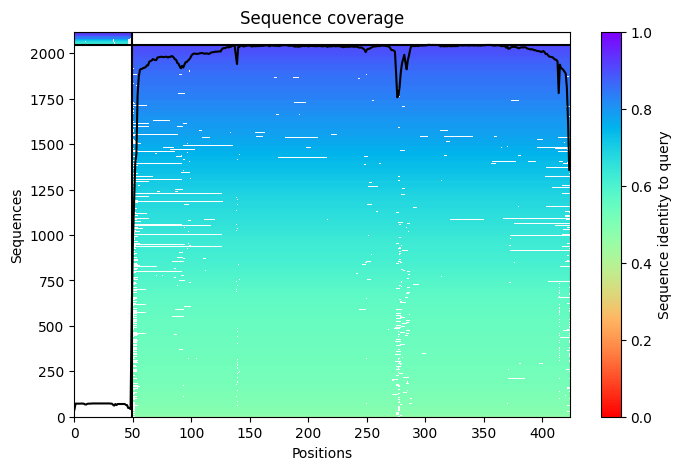

2024-12-21 14:46:25,391 Setting max_seq=508, max_extra_seq=1611


In [ ]:
#@title ALL
!pip install biopython
from google.colab import drive
import pandas as pd
import subprocess
import os
import fileinput
import os
import shutil
from Bio import SeqIO

drive.mount('/content/drive')

result_directory = '/content/drive/My Drive/Uni/Studium/PhD/MSA_sampling/Actin_Peptide/Trial5/results' #@param {type:"string"}
fasta_directory = '/content/drive/My Drive/Uni/Studium/PhD/MSA_sampling/Actin_Peptide/Trial5/fasta'  #@param {type:"string"}
msa_directory = '/content/drive/My Drive/Uni/Studium/PhD/MSA_sampling/Actin_Peptide/Trial5/combined'  #@param {type:"string"}
template_directory = '/content/drive/My Drive/OPTIONAL/path-to-your-custom-templates/' #@param {type:"string"}

def get_folder_id_from_path(drive, path):
    # Remove the local root path if present
    local_root = '/content/drive/My Drive/'
    if path.startswith(local_root):
        path = path[len(local_root):]
    elif path.startswith('/'):
        path = path[1:]  # Remove leading slash if any

    path_parts = path.strip('/').split('/')
    folder_id = 'root'  # Start from the root of Google Drive

    for part in path_parts:
        # Search for the folder with this name in the current directory
        query = f"'{folder_id}' in parents and title='{part}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
        file_list = drive.ListFile({'q': query}).GetList()
        if len(file_list) == 0:
            # Folder doesn't exist; create it
            folder_metadata = {
                'title': part,
                'parents': [{'id': folder_id}],
                'mimeType': 'application/vnd.google-apps.folder'
            }
            folder = drive.CreateFile(folder_metadata)
            folder.Upload()
            folder_id = folder['id']
            print(f"Created folder '{part}' with ID: {folder_id}")
        else:
            # Folder exists; use its ID
            folder_id = file_list[0]['id']
            print(f"Found folder '{part}' with ID: {folder_id}")
    return folder_id


def run_prediction(query_sequence, jobname):
  from google.colab import files
  import os
  import re
  import hashlib
  import random
  import time

  from sys import version_info
  python_version = f"{version_info.major}.{version_info.minor}"

  def add_hash(x,y):
    return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

  # number of models to use
  num_relax = 0 #@param [0, 1, 5] {type:"raw"}
  #@markdown - specify how many of the top ranked structures to relax using amber
  template_mode = "none" #@param ["none", "pdb100","custom"]
  #@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

  use_amber = num_relax > 0

  # remove whitespaces
  query_sequence = "".join(query_sequence.split())

  a3mname = "".join(jobname.split())
  basejobname = "".join(jobname.split())
  basejobname = re.sub(r'\W+', '', basejobname)
  jobname = add_hash(basejobname, query_sequence)

  # check if directory with jobname exists
  def check(folder):
    if os.path.exists(folder):
      return False
    else:
      return True
  if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"): n += 1
    jobname = f"{jobname}_{n}"

  # make directory to save results
  os.makedirs(jobname, exist_ok=True)

  # We will write queries to CSV in one of two ways:
  #   1) For custom MSAs, supply "id,sequence,a3m_file"
  #   2) For mmseqs2 or single_sequence mode, supply "id,sequence" only
  queries_path = os.path.join(jobname, f"{jobname}.csv")

  # ============================================================================
  # CHANGED BLOCK:
  #
  # Decide what to write to `queries_path` depending on msa_mode.
  # For "custom": look for pre-computed a3m_file in `msa_directory`.
  # For mmseqs2_uniref, mmseqs2_uniref_env, or single_sequence, do NOT supply a3m_file.
  # ============================================================================

  msa_mode = "custom"  # @param ["mmseqs2_uniref_env","mmseqs2_uniref","single_sequence","custom"]

  if msa_mode == "custom":
      a3m_file = os.path.join(msa_directory, f"c_{a3mname}.a3m")
      if not os.path.isfile(a3m_file):
          print(f"Error: {a3m_file} not found.")
          return False
      else:
          print(f"Using provided MSA file: {a3m_file}")
      with open(queries_path, "w") as text_file:
          text_file.write(f"id,sequence,a3m_file\n{jobname},{query_sequence},{a3m_file}")
  else:
      # For standard mmseqs2_uniref, mmseqs2_uniref_env, or single_sequence,
      # we let ColabFold generate the MSA automatically.
      with open(queries_path, "w") as text_file:
          text_file.write(f"id,sequence\n{jobname},{query_sequence}")

  # ============================================================================
  # END CHANGED BLOCK
  # ============================================================================
  if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
  elif template_mode == "custom":
    use_templates = True
    custom_template_path = template_directory
  else:
    custom_template_path = None
    use_templates = False

  print("a3mname",a3mname)
  print("jobname",jobname)
  print("sequence",query_sequence)
  print("length",len(query_sequence.replace(":","")))


  #@title Install dependencies

  import os
  USE_AMBER = use_amber
  USE_TEMPLATES = use_templates
  PYTHON_VERSION = python_version

  if not os.path.isfile("COLABFOLD_READY"):
    print("installing colabfold...")
    os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
    os.system("touch COLABFOLD_READY")

  if USE_AMBER or USE_TEMPLATES:
    if not os.path.isfile("CONDA_READY"):
      print("installing conda...")
      os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
      os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
      os.system("mamba config --set auto_update_conda false")
      os.system("touch CONDA_READY")

  if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing hhsuite and amber...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch HH_READY")
    os.system("touch AMBER_READY")
  else:
    if USE_TEMPLATES and not os.path.isfile("HH_READY"):
      print("installing hhsuite...")
      os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
      os.system("touch HH_READY")
    if USE_AMBER and not os.path.isfile("AMBER_READY"):
      print("installing amber...")
      os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
      os.system("touch AMBER_READY")

  #@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
  pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
  #@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.


  #@markdown ### Advanced settings
  model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
  #@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
  #@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
  num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
  #@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
  recycle_early_stop_tolerance = "0.0" #@param ["auto", "0.0", "0.5", "1.0"]
  #@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
  relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
  #@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
  pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
  #@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


  #@markdown #### Sample settings
  #@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
  #@markdown -  decrease `max_msa` to increase uncertainity
  max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
  num_seeds = 1 #@param [1,2,3,4,8,16] {type:"raw"}
  use_dropout = False #@param {type:"boolean"}

  num_recycles = None if num_recycles == "auto" else int(num_recycles)
  recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
  if max_msa == "auto": max_msa = None

  #@markdown #### Save settings
  save_all = False #@param {type:"boolean"}
  save_recycles = False #@param {type:"boolean"}
  save_to_google_drive = True #@param {type:"boolean"}
  #@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
  dpi = 200 #@param {type:"integer"}
  #@markdown - set dpi for image resolution

  if save_to_google_drive:
    from pydrive.drive import GoogleDrive
    from pydrive.auth import GoogleAuth
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    print("You are logged into Google Drive and are good to go!")

  #@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

  #@title Run Prediction
  display_images = True #@param {type:"boolean"}

  import sys
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)
  from Bio import BiopythonDeprecationWarning
  warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
  from pathlib import Path
  from colabfold.download import download_alphafold_params, default_data_dir
  from colabfold.utils import setup_logging
  from colabfold.batch import get_queries, run, set_model_type
  from colabfold.plot import plot_msa_v2

  import os
  import numpy as np
  try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
  except:
    K80_chk = "0"
    pass
  if "1" in K80_chk:
    print("WARNING: found GPU Tesla K80: limited to total length < 1000")
    if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
      del os.environ["TF_FORCE_UNIFIED_MEMORY"]
    if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
      del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

  from colabfold.colabfold import plot_protein
  from pathlib import Path
  import matplotlib.pyplot as plt

  # For some reason we need that to get pdbfixer to import
  if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
      sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

  def input_features_callback(input_features):
    if display_images:
      plot_msa_v2(input_features)
      plt.show()
      plt.close()

  def prediction_callback(protein_obj, length,
                          prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed:
      if display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

  result_dir = jobname
  log_filename = os.path.join(jobname,"log.txt")
  setup_logging(Path(log_filename))

  queries, is_complex = get_queries(queries_path)
  model_type = set_model_type(is_complex, model_type)

  if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
  else:
    use_cluster_profile = True


  try:
    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=5,
        num_recycles=num_recycles,
        relax_max_iterations=relax_max_iterations,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1,2,3,4,5],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        pairing_strategy=pairing_strategy,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
        user_agent="colabfold/google-colab-main",
    )
  except Exception as e:
     print(f"Prediction failed with error: {e}")
     return False

  # Zip the results
  results_zip = f"{jobname}.result.zip"
  zip_cmd = f"zip -r {results_zip} {jobname}"
  if os.system(zip_cmd) != 0:
    print("Zipping results failed.")
    return False

  # Check if ZIP was successfully created
  if not os.path.isfile(results_zip):
    print("Results ZIP not found, prediction might not have completed successfully.")
    return False

  #@title Package and download results
  #@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

  if msa_mode == "custom":
    print("Don't forget to cite your custom MSA generation method.")

  if save_to_google_drive == True and drive:
    folder_id = get_folder_id_from_path(drive, result_directory)
    file_metadata = {
        'title': f"{jobname}.result.zip",
        'parents': [{'id': folder_id}]
    }
    uploaded = drive.CreateFile(file_metadata)
    uploaded.SetContentFile(f"{jobname}.result.zip")
    try:
      uploaded.Upload()
      print(f"Uploaded {jobname}.result.zip to Google Drive in folder '{result_directory}' with ID {uploaded.get('id')}")
    except Exception as e:
      print(f"Upload to Google Drive failed with error: {e}")
      return False

  # If we reach until here, everything completed successfully
  return True


# Create 'done' directory inside fasta_directory
fasta_done_directory = os.path.join(fasta_directory, 'done')
os.makedirs(fasta_done_directory, exist_ok=True)

# Loop over FASTA files and run predictions
for fasta_file in os.listdir(fasta_directory):
    if fasta_file.endswith('.fasta'):
        fasta_path = os.path.join(fasta_directory, fasta_file)

        # Parse the FASTA file to extract sequences
        for record in SeqIO.parse(fasta_path, "fasta"):
            peptide = str(record.seq).strip()
            jobname = os.path.splitext(fasta_file)[0]  # Use the FASTA file name (without extension) as the job name

            print(f"Processing {fasta_file}: Peptide = {peptide}")

            # Run prediction with the peptide sequence and the correct .a3m file
            success = run_prediction(peptide, jobname)

        # Move the FASTA file only if the prediction was successful
        if success:
          shutil.move(fasta_path, os.path.join(fasta_done_directory, fasta_file))
        else:
           print(f"Prediction for {fasta_file} did not complete successfully. Not moving the file.")